<a href="https://colab.research.google.com/github/nunocesarsa/GoogleColab_public/blob/master/Gaussian_Process_DataAugmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')
#Perhaps this step can be skipped by saving directly to the workspace

Mounted at /content/drive


In [266]:
#General purpose: 
import matplotlib.pyplot as plt
import numpy
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

import pandas as pd


#Gaussian processes
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern, WhiteKernel, ExpSineSquared, RationalQuadratic, RBF

#aux functions
from sklearn.preprocessing import MinMaxScaler #this is to standardize the input data [not used for now]
from sklearn import metrics


#for model storing -sklearn
import pickle

#for model storing keras
from keras.models import model_from_json

#a few more stuff for random
import random as rdm
import math


In [267]:
#gaussian processes with default acquisition function
#initializing the gaussian process -optimized
K_ratQ = RationalQuadratic(length_scale_bounds="fixed",alpha_bounds="fixed")
K_RBF = RBF(length_scale_bounds="fixed")

def gpr_call():
  mdl = GaussianProcessRegressor(kernel=K_RBF,
                                  n_restarts_optimizer=80, # -> 1*RBF(1.0) is the default kerneºl
                                  normalize_y=True,
                                  random_state=0,
                                 alpha=.05)
  return mdl
  

In [268]:
#filepath="/content/drive/My Drive/Leon/Leon_Data_Montesinho.csv"
filepath="/content/drive/My Drive/Leon/Leon_data_sel.csv"

field_data = pd.read_csv(filepath,sep=";",decimal=",")

In [351]:
#sorting
tgt_trait ="effPAI"
sort_field_data = field_data.sort_values(by=[tgt_trait])

sel_df = sort_field_data
#sel_df = field_data
#sel_df = field_data.loc[field_data["Land_Use_d"]=="Shrublands"]

spect_df = sel_df[["B2","B3","B4",
                   "B5","B6","B7",
                   "B8","B8A","B11","B12"]]
#spect_df


#trait_df = sel_df[["CAB","CAR","Lth","CDM","CW"]]
#trait_df = sel_df[["CAB"]]
#trait_df = sel_df[["effPAI"]]
#trait_df = sel_df[["CAR"]]
#trait_df = sel_df[["CDM"]]
#trait_df = sel_df[["CW"]]
#trait_df = sel_df[["Lth"]]

trait_df = sel_df[[tgt_trait]]

trait_df

,effPAI
72,0.00
40,0.00
77,0.03
74,0.09
71,0.11
...,...
100,2.60
103,2.68
111,2.72
101,2.90


In [357]:
#selecting a sample

#coverting to numpy
np_sel = sel_df.iloc[:,:].values
np_spc = spect_df.iloc[:,:].values
np_trt = trait_df.iloc[:,:].values

#creating index
index = list(range(len(np_sel)))
index10 = rdm.sample(index,math.ceil(len(index)*.3)) #randomly selects 10% of te data (aproximately)
index90 = [x for x in index if x not in index10] #makes a list with the remaining
index90
index10

#training group
tr_spc = np_spc[index90,]
tr_trt = np_trt[index90,]

vl_spc = np_spc[index10,]
vl_trt = np_trt[index10,]

#calling the GPR and training
gpr_mdl = gpr_call()


Using vegetation indices - optional

In [358]:
ndvi = (np_spc[:,7]-np_spc[:,2])/(np_spc[:,7]+np_spc[:,2])
#training group
tr_spc = ndvi[index90,].reshape(-1, 1)
tr_trt = np_trt[index90,].reshape(-1, 1)

vl_spc = ndvi[index10,].reshape(-1, 1)
vl_trt = np_trt[index10,].reshape(-1, 1)




In [359]:
#training
gpr_mdl.fit(tr_spc,tr_trt)

out_np,sigma = gpr_mdl.predict(vl_spc,return_std=True)
confidence_interval = sigma * 1.96

Mean absolute error: 0.3446944216611154


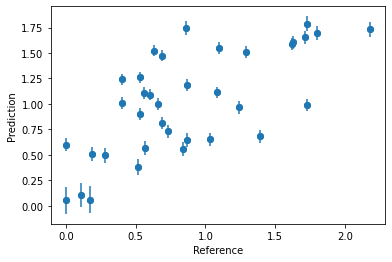

In [364]:
import matplotlib.pyplot as plt


plt.scatter(vl_trt,out_np)
plt.errorbar(vl_trt,out_np,yerr=1.96*sigma,fmt='o')
#plt.xlim((20,25))
#plt.ylim((20,25))

#plt.fill_between(vl_trt[:,0],
#                 out_np[:,0] - confidence_interval,
#                 out_np[:,0] + confidence_interval,
#                 alpha=.9, label='98% confidence interval', color='#B22222')

plt.ylabel("Prediction")
plt.xlabel("Reference")

#plt.fill(np.concatenate([vl_trt, vl_trt[::-1]]),
#         np.concatenate([out_np - 1.9600 * sigma,
#                        (out_np + 1.9600 * sigma)[::-1]]),
#         alpha=.5, fc='b', ec='None', label='95% confidence interval')

#plt.xlim((0.15,.25))
#plt.ylim((0.15,.25))

print("Mean absolute error:",metrics.mean_absolute_error(vl_trt, out_np))


Predicting to an image

In [365]:
import ee

In [366]:
#then we need to authenticate

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=WqE2juNsmi4QPRwyOy8_jAVVQuT96oSeYvY9p0VaHbk&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/4gHhrpaM-_DxLwcvDXVKyDPLBC6e6owD2YafNdgwANSWlfwfnU526bE

Successfully saved authorization token.


In [398]:
#This creates a polygon area which perhaps we can use as a filter
#this next step actually clips the image 
#this is a polygon area created by me, it surrounds the park, perhaps there are better ways of designing this also
#points

mont_larger = [[[-6.58990044211615,41.7829657496439],
                [-6.560460515968689,41.7829657496439],
                [-6.560460515968689,41.80088372804521],
                [-6.58990044211615,41.80088372804521],
                [-6.58990044211615,41.7829657496439]]]




montesinho = [[[-6.57719007,41.79208948],
                [-6.57694957,41.79208441],
                [-6.57719685,41.79190950],
                [-6.57695635,41.79190443],
                [-6.57671586,41.79189935],
                [-6.57696314,41.79171937],
                [-6.57672942,41.79153939]]]

#polygon around ptds
montesinho_poly = [[[-6.578186759257150130,41.79242347910090416], 
                    [-6.575198266868249600,41.79242347910090416], 
                    [-6.575198266868249600,41.79039404444139194], 
                    [-6.578186759257150130,41.79039404444139194],
                    [-6.578186759257150130,41.79242347910090416]]]

montesinho_poly_GEE =[[[-6.581378690132624,41.787597520709510],
                       [-6.570349446663386,41.787597520709510],
                       [-6.570349446663386,41.793452987972174],
                       [-6.581378690132624,41.793452987972174],
                       [-6.581378690132624,41.787597520709510]]]

montesinho_poly_verysmall = [[[-6.5773094211360785,41.79146133161573],[-6.576665690972504,41.79146133161573],
                              [-6.576665690972504,41.792257242638115],[-6.5773094211360785,41.792257242638115],
                              [-6.5773094211360785,41.79146133161573]]]


monte_even_smaller=[[[-6.5773425755776902,41.79217166803000083], [-6.57659526795104821,41.79219577472763802], 
                [-6.5765149122922697,41.7914323959692382], [-6.57727829105066775,41.7914323959692382], 
                [-6.5773425755776902,41.79217166803000083]]]

poly_montesinho = ee.Geometry.Polygon(mont_larger)


# it is quite COMPLEX to use the s2 filters in python
s2_collection = (ee.ImageCollection("COPERNICUS/S2_SR") #selects the S2 Surface reflectance product in GEE
                 .select(['B2','B3','B4',
                          'B5','B6','B7',
                          'B8A','B11','B12']) #selects the bands of interest
                 .filter(ee.Filter.date('2019-01-01','2019-12-31')) #filtes on the time
                 .filterBounds(poly_montesinho) #filters on the Aoi
                 .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',10))
                 .filter(ee.Filter.lt('MGRS_TILE','29TQG')))

count = s2_collection.size()
print('Nr of images in collection: ', str(count.getInfo())+'\n')

Nr of images in collection:  20



In [399]:
#this loads a pre-selected image, i reckon it can be a loop - this data is TOA
s2_img = ee.Image("COPERNICUS/S2/20190717T104029_20190717T104353_T31UFU").select(['B2','B3','B4',
                                                                                  'B5','B6','B7',
                                                                                  'B8A','B11','B12'])

#this on is suppose to be the surface reflectance
s2_img = ee.Image("COPERNICUS/S2_SR/20190717T104029_20190717T104353_T31UFU").select(['B2','B3','B4',
                                                                                  'B5','B6','B7',
                                                                                  'B8A','B11','B12'])


#this selects an miage from the above list, change here to get the other data on the list
mid_step = s2_collection.toList(count)
s2_img = ee.Image(mid_step.get(0))

#s2_img.getInfo()

In [400]:
s2_img_meta = s2_img.getInfo()
print('Granule ID: ',s2_img_meta.get('properties',{}).get('GRANULE_ID'))

Granule ID:  L2A_T29TPG_A018481_20190105T112819


In [401]:
#first step now is to then generate a s2 image cropped to our aoi, and for information i will also plot it on the map

# Import the Folium library. This library is to assist in visualizations
import folium
from folium import Marker

# Import the Image function from the IPython.display module. 
from IPython.display import Image


#the next code snippet i stole from someone
# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
  
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer


# Set visualization parameters.
visParams = {"bands": ['B8A', 'B4', 'B3'],"gain": '0.1, 0.1, 0.1',"scale":20}

# Create a folium map object.
#my_map = folium.Map(location=[52.4500, 5.35], zoom_start=12) #this had to be tried one by one... feels daft
my_map = folium.Map(location=[41.791, -6.577], zoom_start=15) #this had to be tried one by one... feels daft


# Add the elevation model to the map object.
my_map.add_ee_layer(s2_img, visParams, 'DEM')

# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())

# Display the map.
display(my_map)

In [402]:
#dates is a bit more complicated - thank olga! 
date_t1 = ee.Date(s2_img_meta.get('properties',{}).get('system:time_start')).format("YYYY_MM_DD").getInfo()
date_t2 = ee.Date(s2_img_meta.get('properties',{}).get('system:time_start')).format("YYYY_MM_dd").getInfo()
print('Time in Annual calendar: YYYY - year; MM - month of year; DD day of year ', date_t1)
print('Time in Annual calendar: YYYY - year; MM - month of year; DD day of month ', date_t2)

#Extracting a name from the image
sens_id = s2_img_meta.get('properties',{}).get('PRODUCT_ID')[:10]
print('Sensor ID: ',)
#extracting the id of the GRID
grid_id = s2_img_meta.get('properties',{}).get('GRANULE_ID')[4:10]
print('GRID ID: ',grid_id)

s2_filename = sens_id+"_"+grid_id+"_"+date_t2
#s2_filename = sens_id+"_"+grid_id+"_"+"small"+"_"+date_t2
s2_filename

Time in Annual calendar: YYYY - year; MM - month of year; DD day of year  2019_01_05
Time in Annual calendar: YYYY - year; MM - month of year; DD day of month  2019_01_05
Sensor ID: 
GRID ID:  T29TPG


'S2A_MSIL2A_T29TPG_2019_01_05'

In [408]:
#it will save  the data to my drive
task_config = {
    'image': s2_img,
    'fileFormat': 'GeoTIFF',
    'fileNamePrefix': s2_filename,
    'description': s2_filename,
    'scale':20,
    'region':poly_montesinho
}
task = ee.batch.Export.image.toDrive(**task_config )
task.start()

In [410]:
task.status()

{'creation_timestamp_ms': 1601305494600,
 'description': 'S2A_MSIL2A_T29TPG_2019_01_05',
 'destination_uris': ['https://drive.google.com/'],
 'id': '2R7DOGC6WDVXF4EQJAT4FTG5',
 'name': 'projects/earthengine-legacy/operations/2R7DOGC6WDVXF4EQJAT4FTG5',
 'start_timestamp_ms': 1601305507353,
 'state': 'COMPLETED',
 'task_type': 'EXPORT_IMAGE',
 'update_timestamp_ms': 1601305516754}

In [ ]:
!pip install pyrsgis
!pip install rasterio
!pip install pyproj

In [411]:
#General purpose: 
import matplotlib.pyplot as plt
import numpy
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

import pandas as pd

import os
from pyrsgis import raster

import rasterio
import rasterio.plot
import pyproj
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [412]:
#This loads the data - we can put the path to the drive itself if we want.. very easy 
#or just substitute it by the filename
#s2_data = 'drive/My Drive/S2_ML_Data_SR_20190730.tif'

#loads a data generated through GEE into your own drive
s2_data = '/content/drive/My Drive/' + s2_filename +".tif" #just add it with the path and you are good to go

#loading an uploaded data from THEIA collection
#s2_data = '/content/S2_20190215_AOI_Theia.tif' #just add it with the path and you are good to go


ds1, bands = raster.read(s2_data)
print(ds1)
print(bands.shape) #the raster has 9 bands by 501 x 590 (not sure wich is the row)


(9, 104, 126)


In [413]:
from pyrsgis.convert import changeDimension

#this function converts the hypercube to a 2D array

bandByPixel = changeDimension(bands)/10000. #we have to devide all values by 10k - its a conversion from bits to reflectances
bandByPixel_t = np.transpose(bandByPixel)
print(bandByPixel.shape)
print(bandByPixel_t.shape)
bandByPixel

import scipy
from scipy import stats
print(scipy.stats.describe(changeDimension(bands)))
print(scipy.stats.describe(bandByPixel))

(13104, 9)
(9, 13104)
DescribeResult(nobs=13104, minmax=(array([  1,   1,   1,   0, 180, 213, 206, 232,  98]), array([1040, 1412, 1616, 1754, 2876, 3315, 3528, 3103, 2141])), mean=array([ 159.98076923,  355.86362943,  405.03212759,  681.70688339,
       1273.85905067, 1414.11401099, 1565.94398657, 1485.48954518,
        948.79090354]), variance=array([ 13131.62185407,  26189.83280972,  55762.48473436,  66138.68069443,
       103482.69546414, 124717.77193525, 136390.71471313, 289392.22274042,
       166803.20026526]), skewness=array([0.74300995, 0.65205993, 0.85858616, 0.52098953, 0.56326174,
       0.66818715, 0.58554079, 0.02103775, 0.11178475]), kurtosis=array([ 0.63860981,  0.35387572,  0.40056906, -0.05814738,  1.71683261,
        2.14061788,  1.90861082, -0.71518721, -0.86219035]))
DescribeResult(nobs=13104, minmax=(array([0.0001, 0.0001, 0.0001, 0.    , 0.018 , 0.0213, 0.0206, 0.0232,
       0.0098]), array([0.104 , 0.1412, 0.1616, 0.1754, 0.2876, 0.3315, 0.3528, 0.3103,
       0

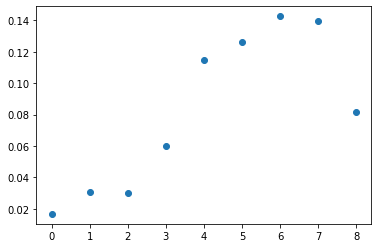

In [414]:
plt.scatter(range(9),bandByPixel[10*10,:])

Text(0, 0.5, 'Row #')

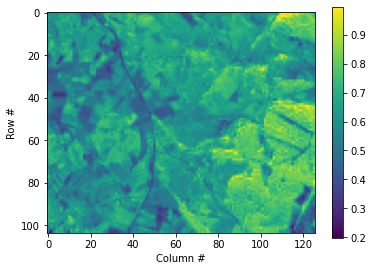

In [419]:
#window = rasterio.windows.Window(1024, 1024, 1280, 2560)
with rasterio.open(s2_data) as src:
  b8A = src.read(7)/10000.
with rasterio.open(s2_data) as src:
  b4 = src.read(2)/10000.         

numpy.seterr(divide='ignore', invalid='ignore')
ndvi = (b8A.astype(float) - b4.astype(float)) / (b8A + b4)
bandByPixel_ndvi = changeDimension(ndvi)


plt.figure(figsize=(6,8.5))
plt.imshow(ndvi)
plt.colorbar(shrink=0.5)
#plt.title(f'Band 4 Subset\n{window}')
plt.xlabel('Column #')
plt.ylabel('Row #')

In [440]:
#bandByPixel_ndvi.shape
#vl_spc.shape

(13104,)

If the raster is small, this direct prediction can be used otherwise it will fail

In [442]:
out_img,out_std = gpr_mdl.predict(bandByPixel_ndvi.reshape(-1, 1),return_std=True)

In [447]:
out_img_rst = np.reshape(out_img,(ds1.RasterYSize,ds1.RasterXSize))
out_std_rst = np.reshape(out_std/np.mean(out_img),(ds1.RasterYSize,ds1.RasterXSize))

Text(0, 0.5, 'Row #')

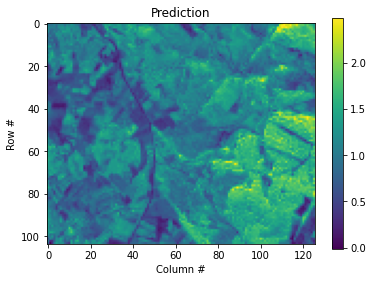

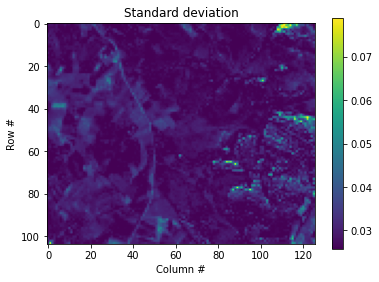

In [448]:
#in a GIS we can easily change the color scale to avoid the extremes
plt.figure(figsize=(6,8.5))
plt.imshow(out_img_rst)
plt.colorbar(shrink=0.5)
plt.title('Prediction')
plt.xlabel('Column #')
plt.ylabel('Row #')

plt.figure(figsize=(6,8.5))
plt.imshow(out_std_rst)
plt.colorbar(shrink=0.5)
plt.title('Standard deviation')
plt.xlabel('Column #')
plt.ylabel('Row #')

In [450]:
out_img_rst_outfile = s2_filename + "_effLAI_GPR"+".tif"
out_std_rst_outfile = s2_filename + "_effLAI_GPR_cv"+".tif"

raster.export(out_img_rst, ds1, out_img_rst_outfile, dtype='float')
raster.export(out_std_rst, ds1, out_std_rst_outfile, dtype='float')


END OF TRIAL

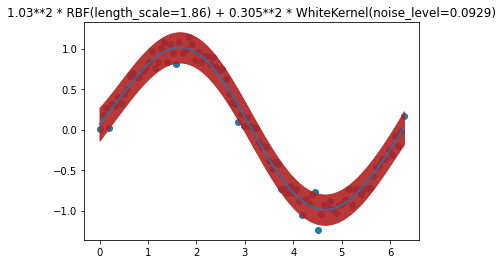

In [330]:
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
import matplotlib.pyplot as plt

kernel = 1.0 * RBF(length_scale=1) + 1.0 * WhiteKernel()

X = np.linspace(0, 2 * np.pi, 100)[:, np.newaxis]
y = np.sin(X)[:, 0] + 0.1 * np.random.randn(100)
gp = gaussian_process.GaussianProcessRegressor(kernel=kernel)
gp.fit(X, y)
pred_y, sigma = gp.predict(X, return_std=True)
confidence_interval = sigma * 1.96

plt.scatter(X, y, label='Train data')
plt.fill_between(X[:, 0],
                 pred_y - confidence_interval,
                 pred_y + confidence_interval,
                 alpha=.9, label='98% confidence interval', color='#B22222')
plt.gca().set_title(gp.kernel_)
plt.plot(X, pred_y, label='Prediction')

In [331]:
print((pred_y - confidence_interval).shape)

(100,)


In [332]:
pred_y.shape

(100,)

In [261]:
pred_y + confidence_interval

array([ 0.26509924,  0.32070753,  0.37760477,  0.43527968,  0.49323305,
        0.55098988,  0.60810771,  0.66418114,  0.71884335,  0.77176537,
        0.82265392,  0.87124849,  0.91731815,  0.9606583 ,  1.00108773,
        1.03844588,  1.0725906 ,  1.10339621,  1.13075201,  1.15456119,
        1.17473999,  1.19121727,  1.20393425,  1.21284454,  1.21791418,
        1.21912189,  1.2164593 ,  1.20993115,  1.19955551,  1.18536391,
        1.16740136,  1.14572636,  1.12041077,  1.09153966,  1.05921105,
        1.02353571,  0.98463682,  0.94264973,  0.89772162,  0.85001131,
        0.79968892,  0.7469357 ,  0.69194372,  0.6349157 ,  0.57606467,
        0.51561373,  0.45379562,  0.39085228,  0.3270343 ,  0.26260024,
        0.19781579,  0.13295285,  0.06828839,  0.00410321, -0.05931947,
       -0.12169549, -0.18274143, -0.24217629, -0.2997233 , -0.35511171,
       -0.40807868, -0.45837102, -0.50574702, -0.54997814, -0.59085066,
       -0.62816722, -0.66174825, -0.6914333 , -0.71708231, -0.73